In [58]:
from pathlib import Path
import struct
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LogNorm, ListedColormap
from matplotlib.ticker import MultipleLocator, ScalarFormatter

from scipy.stats import gaussian_kde


def standard_colormap() -> np.ndarray:
    hex_vals = [
        ("FF","FF","FF"),("00","00","FF"),("16","85","E9"),("87","A0","F8"),
        ("85","F7","FA"),("1A","E6","A4"),("20","E4","1B"),("97","EB","25"),
        ("D3","F8","07"),("F7","D3","31"),("FC","B5","6D"),("FF","80","80"),
        ("FF","00","00"),
    ]
    return np.array([[int(h,16)/255. for h in triple] for triple in hex_vals])


def prpd_histogram(t: np.ndarray,
                   phase: np.ndarray,
                   pdevents: np.ndarray,
                   pdMin: float,
                   pdMax: float,
                   bipolar: bool,
                   logarithmic: bool,
                   numXPoints: int,
                   numYPoints: int):
    """
    Build a PRPD histogram exactly like histogram.m

    Args:
        t           : 1D time vector
        phase       : 1D phase vector (0–1)
        pdevents    : 1D PD magnitude vector
        pdMin       : lower magnitude bound (was qMin)
        pdMax       : upper magnitude bound (was qMax)
        bipolar     : if True, center bipolar counts
        logarithmic : if True, use log10 scaling
        numXPoints  : width (# of phase bins)
        numYPoints  : height (# of magnitude bins)

    Returns:
        hist_counts : 2D array (numYPoints × numXPoints) of event rates
        hist_colors : 2D array of colormap indices (1‑based)
        hist_image  : hist_colors flipped vertically (for imshow)
    """
    maxy = numYPoints // (2 if bipolar else 1)

    if logarithmic:
        gain   = maxy / np.log10(pdMax / pdMin)
        offset = -np.log10(pdMin) * gain
    else:
        gain   = maxy / (pdMax - pdMin)
        offset = -pdMin * gain

    # truncate at first zero PD event
    zero_idx = np.nonzero(pdevents == 0)[0]
    n = zero_idx[0] if zero_idx.size else min(len(t), len(phase), len(pdevents))
    t        = t[:n]
    phase    = phase[:n]
    pdevents = pdevents[:n]
    dt       = t[-1] - t[0]

    # map to bin indices
    if logarithmic:
        mags = np.round(np.log10(np.abs(pdevents)) * gain + offset)
    else:
        mags = np.round((np.abs(pdevents) if not bipolar else pdevents) * gain + offset)

    xs = np.round(phase * (numXPoints - 1) + 1)
    mags = mags.astype(int)
    xs   = xs.astype(int)

    if logarithmic and bipolar:
        mags[pdevents < 0] *= -1

    if bipolar:
        mags = np.round(mags + numYPoints * 0.5).astype(int)

    # keep only valid bins
    mask = (mags > 0) & (mags <= numYPoints) & (xs > 0) & (xs <= numXPoints)
    mags = mags[mask] - 1
    xs   = xs[mask]   - 1

    # accumulate counts
    hist_counts = np.zeros((numYPoints, numXPoints), dtype=float)
    np.add.at(hist_counts, (mags, xs), 1)
    hist_counts /= dt

    # color indexing
    cm     = standard_colormap()
    numCol = cm.shape[0]
    hc     = np.zeros_like(hist_counts, dtype=int)

    mx = hist_counts.max()
    mn = hist_counts[hist_counts>0].min() if np.any(hist_counts>0) else 1.0
    m    = ((mx * 0.85) / mn)**(numCol/(numCol-1)) * mn
    root = (m/mn)**(1/numCol)
    prev = mx + 1

    for i in range(1, numCol+1):
        val = mn * root**(numCol - i)
        mask_i = (hist_counts >= val) & (hist_counts < prev)
        hc[mask_i] = numCol - i + 1
        prev = val

    hist_image = np.flipud(hc)
    return hist_counts, hc, hist_image

In [59]:
def import_pd_data(folder: str, q_unit: str) -> np.ndarray:
    """
    Import partial discharge data from a .PD file and return a single (N×2) array.

    Each 12-byte record contains:
      • bytes 0–3: float32 measurement q
      • bytes 4–11: float64 timestamp q_tm

    Args:
        folder: Path to the directory containing the .PD file.
        q_unit: Base filename (without “.PD”) to open.

    Returns:
        data: NumPy array of shape (N, 2), where
              data[:, 0] == q_tm (float64),
              data[:, 1] == q    (float32).
    """
    path = os.path.join(folder, f"{q_unit}.PD")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"No such file: {path}")

    # Read entire file
    with open(path, 'rb') as f:
        raw = f.read()

    L = len(raw)
    n_records = L // 12
    buf = np.frombuffer(raw, dtype=np.uint8, count=n_records*12)
    recs = buf.reshape(n_records, 12)

    # Extract measurement q (float32 from bytes 0–3)
    q = recs[:, 0:4].view('<f4').ravel()
    # Extract time   q_tm (float64 from bytes 4–11)
    q_tm = recs[:, 4:12].view('<f8').ravel()

    # Stack into one (N,2) array: [time, measurement]
    data = np.column_stack((q_tm, q))
    return data

In [60]:
def import_ac_data(folder: str, ACUnit: str):
    """
    Import AC data from a .AC file.

    Each block in the file has the layout:
      • t0    : float64
      • f_d   : float64
      • dc    : float64 (NaN → 0)
      • n     : uint8   (number of Fourier coefficient pairs)
      • 2*n float64s: real1, imag1, real2, imag2, … real_n, imag_n

    We pack each set into a (4 × 24) matrix:
      row 0 = [dc,    AC_real(1)…AC_real(23)]
      row 1 = [0,     AC_imag(1)…AC_imag(23)]
      row 2 = [0,    f_d, 2f_d … 23f_d]
      row 3 = [t0,    0…0]

    Returns:
      AC_coeffs       : np.ndarray, shape (4,24,num_sets)
      voltage_sample_at : function(t: float, coeffs) → float
      voltage_vec       : function(t_array: np.ndarray, coeffs) → np.ndarray
    """
    path = os.path.join(folder, f"{ACUnit}.AC")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"No such file: {path}")

    coeffs_list = []
    with open(path, 'rb') as f:
        while True:
            # read t0, f_d, dc, n
            header = f.read(8*3 + 1)
            if len(header) < 8*3 + 1:
                break
            t0, f_d, dc = struct.unpack('<ddd', header[:24])
            n = struct.unpack('<B', header[24:25])[0]

            # fix dc NaN
            if np.isnan(dc):
                dc = 0.0

            if n == 0:
                continue

            # read 2*n float64s (real/imag pairs)
            data_bytes = f.read(8 * 2 * n)
            if len(data_bytes) < 8*2*n:
                break
            vals = np.frombuffer(data_bytes, dtype='<f8')
            real = vals[0::2]
            imag = vals[1::2]

            # pad or truncate to 23 coefficients
            if real.size < 23:
                real = np.pad(real, (0, 23 - real.size))
            else:
                real = real[:23]
            if imag.size < 23:
                imag = np.pad(imag, (0, 23 - imag.size))
            else:
                imag = imag[:23]

            # build the 4×24 block
            real_row = np.concatenate(([dc], real))
            imag_row = np.concatenate(([0.0], imag))
            freq_row = np.concatenate(([0.0], np.arange(1, 24) * f_d))
            time_row = np.concatenate(([t0], np.zeros(23)))

            block = np.vstack([real_row, imag_row, freq_row, time_row])
            coeffs_list.append(block)

    if not coeffs_list:
        # no data found
        AC_coeffs = np.empty((4, 24, 0))
    else:
        AC_coeffs = np.stack(coeffs_list, axis=2)

    # helper functions
    def voltage_sample_at(t: float, coeffs: np.ndarray) -> float:
        # pick the latest set whose t0 < t
        t0s = coeffs[3, 0, :]
        idx = np.where(t0s < t)[0]
        i = idx.max() if idx.size else coeffs.shape[2] - 1
        r = coeffs[0, :, i]
        im = coeffs[1, :, i]
        f = coeffs[2, :, i]
        dt = t - coeffs[3, 0, i]
        return np.sum(r * np.cos(2 * np.pi * f * dt) - im * np.sin(2 * np.pi * f * dt))

    def voltage_vec(t_arr: np.ndarray, coeffs: np.ndarray) -> np.ndarray:
        # reconstruct over a vector of times
        return np.array([voltage_sample_at(t, coeffs) for t in t_arr])

    return AC_coeffs, voltage_sample_at, voltage_vec


In [61]:
# Ask the user for a path (e.g. C:\Users\you\Documents\report.pdf)
filepath_str = input("Enter the full file path for the (.PD) file: ").strip().strip('"')

# Convert the string to a Path object
filepath = Path(filepath_str)

# Extract the directory (parent) and the file name separately
folder   = filepath.parent          # PosixPath or WindowsPath object
filename = filepath.name            # Just the file’s name with extension

print(f"Folder : {folder}")
print(f"Filename: {filename}")

data = import_pd_data(
    folder=folder,
    q_unit=filename.removesuffix('.PD')  # remove the file extension
)
AC_coeffs, sample_fn, vec_fn = import_ac_data(folder, filename.removesuffix('.PD'))

Folder : C:\Users\sapierso\Box\PD-Acoustic Project Data\3rd Party Export (MATLAB)\20250512_11h13m42s
Filename: MPD 800 2.1.1-20250416_12h33m10s365ms.PD


In [62]:
# single time
v_at_1s = sample_fn(1.234, AC_coeffs)

# vector of times
t = np.linspace(0, 10, 1001)
v = vec_fn(t, AC_coeffs)

# Print the overall shape: (4, 24, N_blocks)
print("AC_coeffs shape:", AC_coeffs.shape)

# Peek at the first block of 4×24 coefficients
print("First coefficient set (block 0):\n", AC_coeffs[:, :, 0])

# take block k = 0 (for example)
block0 = AC_coeffs[:, :, 0].T   # shape (24,4) so each row is one coefficient
df = pd.DataFrame(block0,
                  columns=["Real", "Imag", "Freq", "t0"],
                  index=[f"Coeff {i}" for i in range(24)])
display(df)

AC_coeffs shape: (4, 24, 166)
First coefficient set (block 0):
 [[ 0.00000000e+00 -1.79582762e+02  1.00930226e+00  7.68952785e-03
  -3.06461805e-02  4.88856040e+00  5.58664944e-02  3.66819566e-01
   2.21136406e-02  4.14489449e-01  1.52265913e-02  1.07984326e+00
   3.29901876e-02  7.68386227e-01 -1.02236630e-02  2.94970566e-03
   4.71147838e-03 -2.29303734e-01  9.31586197e-03  2.64359444e-01
  -1.10403647e-02  1.04975950e-01  5.30632515e-03  4.14711326e-01]
 [ 0.00000000e+00  4.65159522e+02  1.37887588e+00  3.28260668e+00
  -2.43199076e-01 -1.55401809e+00  1.95692445e-01  2.14041073e+00
   3.61566888e-03  1.73504675e-01  1.23535813e-02  2.68481720e-01
  -1.81600420e-02 -2.83061358e-01  4.47648365e-03 -2.09027261e-01
   4.47285688e-03 -2.47661312e-01 -1.77747122e-02  4.87852547e-01
   4.32410309e-03  1.16533146e-01  4.38199970e-03 -7.05892005e-02]
 [ 0.00000000e+00  6.00194717e+01  1.20038943e+02  1.80058415e+02
   2.40077887e+02  3.00097358e+02  3.60116830e+02  4.20136302e+02
   4.80155

,Real,Imag,Freq,t0
Coeff 0,0.000000,0.000000,0.000000,0.684848
Coeff 1,-179.582762,465.159522,60.019472,0.000000
Coeff 2,1.009302,1.378876,120.038943,0.000000
Coeff 3,0.007690,3.282607,180.058415,0.000000
Coeff 4,-0.030646,-0.243199,240.077887,0.000000
Coeff 5,4.888560,-1.554018,300.097358,0.000000
Coeff 6,0.055866,0.195692,360.116830,0.000000
Coeff 7,0.366820,2.140411,420.136302,0.000000
Coeff 8,0.022114,0.003616,480.155773,0.000000
Coeff 9,0.414489,0.173505,540.175245,0.000000


## Process AC Data

In [63]:
# make a time vector (e.g. from the first t0 up to last + 1s)
t0_min = AC_coeffs[3,0,0]
t0_max = AC_coeffs[3,0,-1]
print(f"t0_min: {t0_min}, t0_max: {t0_max}")

fs = 5000
t = np.arange(t0_min, t0_max + 1.0, 1/fs)

# compute the voltage trace
v = vec_fn(t, AC_coeffs)

# simple RMS (includes any DC offset)
rms = np.sqrt(np.mean(v**2))
print(f"RMS voltage = {rms:.3f} V")

# removed the DC offset from AC RMS
v_ac = v - np.mean(v)
rms_ac = np.sqrt(np.mean(v_ac**2))
print(f"AC‑only RMS voltage = {rms_ac:.3f} V")

t0_min: 0.6848479942500001, t0_max: 50.01055999425
RMS voltage = 912.127 V
AC‑only RMS voltage = 912.127 V


In [64]:
# — parameters — 
fs = 5000               # sampling rate you used with arange()
window_ms = 100         # size of each RMS window in milliseconds
win_samples = int(window_ms/1000 * fs)

# assume you already have:
#   t : 1‑D time array
#   v : 1‑D voltage array (same length as t)

# trim off the tail so we have an integer number of windows
n_full = len(v) // win_samples
v_trim = v[:n_full * win_samples]
t_trim = t[:n_full * win_samples]

# reshape into (n_windows, win_samples)
v_w = v_trim.reshape(n_full, win_samples)
t_w = t_trim.reshape(n_full, win_samples)

# compute RMS per window
rms = np.sqrt(np.mean(v_w**2, axis=1))

# compute a time for each window, e.g. the center
t_rms = t_w.mean(axis=1)

## Process PD Data

In [65]:
# Assuming `data` is your (N×2) array already in memory:
time = data[:, 0]
measurements = data[:, 1]
ymax = np.max(np.abs(measurements))

## Plotting

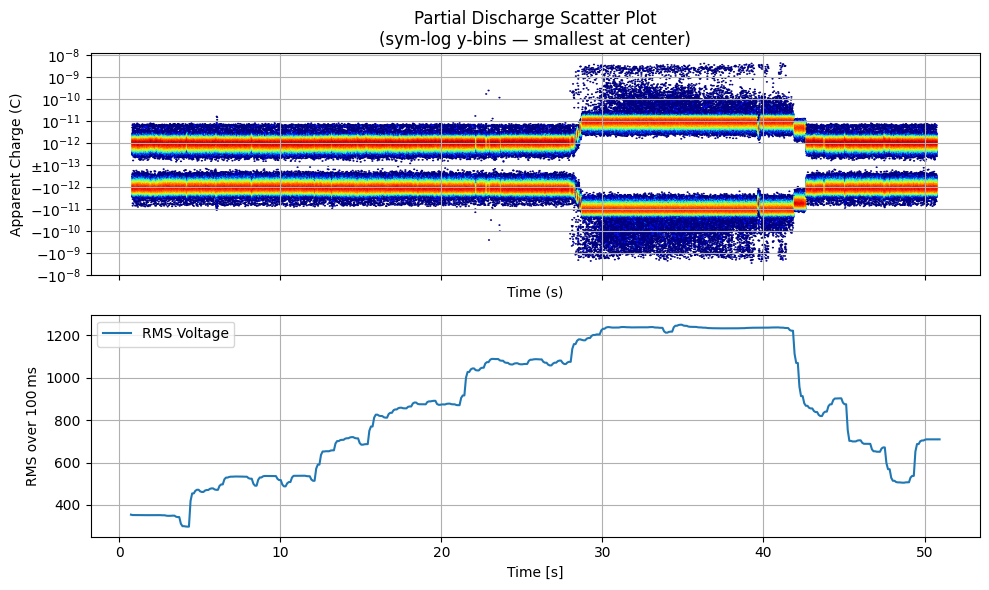

In [67]:
# — plotting —
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)


### PD scatter

# 1) mask exact zeros
mask    = measurements != 0
x       = time[mask]
y_raw   = measurements[mask]

# 2) true log10 of magnitudes
log_abs = np.log10(np.abs(y_raw))

# 3) integer bounds
exp_min = int(np.floor(log_abs.min()))   # e.g. -13
exp_max = int(np.ceil (log_abs.max()))   # e.g.  -8

# 4) shift so smallest magnitude → 0, largest → (exp_max - exp_min)
m       = log_abs - exp_min
M       = exp_max - exp_min

# 5) signed‑shifted coordinate
y_sym   = np.sign(y_raw) * m

# 6) hexbin in the transformed space
hb = ax1.hexbin(
    x, y_sym,
    gridsize=1000,
    cmap='jet',
    norm=LogNorm(vmin=1),
    mincnt=1
)
# fig.colorbar(hb, ax=ax1, label='Counts (log scale)')

# 7) tick locations from -M…0…+M
ticks = np.arange(-M, M+1)

# 8) labels back to ±10^n using our integer exp_min
labels = []
for t in ticks:
    if   t >  0:
        # positive side → +10^(exp_min + t)
        labels.append(f"$10^{{{exp_min + t}}}$")
    elif t <  0:
        # negative side → -10^(exp_min + |t|)
        labels.append(f"$-10^{{{exp_min + abs(t)}}}$")
    else:
        # center → the smallest magnitude
        labels.append(f"$±10^{{{exp_min}}}$")
ax1.set_yticks(ticks)
ax1.set_yticklabels(labels)

# 9) formatting
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Apparent Charge (C)')
ax1.set_title('Partial Discharge Scatter Plot\n(sym‑log y‑bins — smallest at center)')
ax1.grid(True)


### windowed RMS
ax2.plot(t_rms, rms, linestyle='-', label='RMS Voltage')
ax2.set(xlabel="Time [s]", ylabel=f"RMS over {window_ms} ms")
ax2.grid(True)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()